# Libraries

## To do
- Połączyć dane z kaggle
- Zrobić na tabeli per gość

## Libraries

In [159]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt # Plotting
import difflib # Fuzzy matching
import csv 
from datetime import datetime

import requests 
from bs4 import BeautifulSoup
from time import sleep
from lxml import etree
from selenium import webdriver
from selenium.webdriver.support.ui import Select

import re
from docx import Document
import nltk
from itertools import chain
import heapq

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [196]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: '%.2f' %x)

In [197]:
# Center all plots by CSS
from IPython.core.display import HTML

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    margin:auto;
    }
.prompt 
    display:none;
}  
</style>
""")

### Stopwords

In [135]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\szmar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\szmar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\szmar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\szmar\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\szmar\AppData\Roaming\nltk_data...


True

# Data import and transformation

About the data:
...
Source (podcast transcripts): https://drive.google.com/drive/folders/1SXN8c3WHWLX0HSDUjwpOSIWfwGRxRlBB
Source (Board Game Geek): https://www.kaggle.com/jvanelteren/boardgamegeek-reviews

## Import the Word documents

In [3]:
document_list = []
for i in range(9):
    document = Document('data/raw/Podcast_9{}.docx'.format(i))
    document_list.append(document)

## Import the Board Game Geek data

In [144]:
game_data = pd.read_csv('data\games_detailed_info.csv', low_memory=False)

In [149]:
game_data.columns

Index(['Unnamed: 0', 'Abstract Game Rank', 'Accessory Rank', 'Amiga Rank',
       'Arcade Rank', 'Atari ST Rank', 'Board Game Rank',
       'Children's Game Rank', 'Commodore 64 Rank', 'Customizable Rank',
       'Family Game Rank', 'Party Game Rank', 'RPG Item Rank',
       'Strategy Game Rank', 'Thematic Rank', 'Video Game Rank',
       'War Game Rank', 'alternate', 'average', 'averageweight',
       'bayesaverage', 'boardgameartist', 'boardgamecategory',
       'boardgamecompilation', 'boardgamedesigner', 'boardgameexpansion',
       'boardgamefamily', 'boardgameimplementation', 'boardgameintegration',
       'boardgamemechanic', 'boardgamepublisher', 'description', 'id', 'image',
       'maxplayers', 'maxplaytime', 'median', 'minage', 'minplayers',
       'minplaytime', 'numcomments', 'numweights', 'owned', 'playingtime',
       'primary', 'stddev', 'suggested_language_dependence',
       'suggested_num_players', 'suggested_playerage', 'thumbnail', 'trading',
       'type', 'usersr

In [156]:
game_data.describe()

,Unnamed: 0,Abstract Game Rank,Accessory Rank,Amiga Rank,Arcade Rank,Atari ST Rank,Children's Game Rank,Commodore 64 Rank,Customizable Rank,Family Game Rank,...,numcomments,numweights,owned,playingtime,stddev,trading,usersrated,wanting,wishing,yearpublished
count,17063.000000,953.000000,1.0,1.0,1.0,1.0,767.000000,1.0,280.000000,1806.000000,...,17063.000000,17063.000000,17063.000000,17063.000000,17063.000000,17063.000000,17063.000000,17063.000000,17063.000000,17063.000000
mean,8531.000000,478.527807,112.0,203.0,154.0,120.0,384.000000,158.0,140.500000,903.728682,...,205.030886,53.237414,1272.048995,96.987868,1.509930,42.803610,780.384047,42.974330,196.966008,1983.562738
std,4925.808157,276.735546,NaN,NaN,NaN,NaN,221.558119,NaN,80.973247,521.797286,...,616.158282,207.520685,4312.073578,1083.019880,0.277346,95.053417,3084.919898,119.788422,642.019913,208.931571
min,0.000000,1.000000,112.0,203.0,154.0,120.0,1.000000,158.0,1.000000,1.000000,...,0.000000,0.000000,3.000000,0.000000,0.219673,0.000000,29.000000,0.000000,0.000000,-3500.000000
25%,4265.500000,239.000000,112.0,203.0,154.0,120.0,192.500000,158.0,70.750000,452.250000,...,25.000000,5.000000,143.000000,30.000000,1.319860,5.000000,56.000000,3.000000,12.000000,1999.000000
50%,8531.000000,478.000000,112.0,203.0,154.0,120.0,384.000000,158.0,140.500000,903.500000,...,50.000000,10.000000,301.000000,45.000000,1.473280,14.000000,119.000000,9.000000,34.000000,2009.000000
75%,12796.500000,718.000000,112.0,203.0,154.0,120.0,575.500000,158.0,210.250000,1354.750000,...,135.000000,29.000000,808.000000,90.000000,1.652180,39.000000,373.000000,29.000000,113.000000,2015.000000
max,17062.000000,957.000000,112.0,203.0,154.0,120.0,767.000000,158.0,280.000000,1807.000000,...,16330.000000,6950.000000,125254.000000,120000.000000,4.029520,2247.000000,85332.000000,2074.000000,13318.000000,2020.000000


In [157]:
game_data['primary']

0                                                    Catan
1                                              Carcassonne
2                                                 Pandemic
3                                                7 Wonders
4                                                 Dominion
                               ...                        
17058                                      Immer oben auf!
17059                           Antarctica (first edition)
17060                                           Jade König
17061    Perfidious Albion: Napoleon's (Hypothetical) I...
17062                            LEGO Constructionary Game
Name: primary, Length: 17063, dtype: object

### Define a function to extract headings

In [4]:
def iter_headings(paragraphs):
    for paragraph in paragraphs:
        if paragraph.style.name.startswith('Heading'):
            yield paragraph

### Proces the documents

In [19]:
results = pd.DataFrame()

for z in document_list:
    
    # Create an empty list for all headings
    heading_list = []
    
    # Extraction headings from this document
    for heading in iter_headings(z.paragraphs):
        heading_list.append(heading.text)

    # Remove the intro and outro
    heading_list = heading_list[1:-1]
    
    text_lines = []

    for i,para in enumerate(z.paragraphs):
        if para.text in heading_list:
            text_lines.append(i)

    #extracting text lines for games only (without intro and outro)       
    gamesText = []
    for k,j in enumerate(text_lines):
        for y, parar in enumerate(z.paragraphs):
            if y>=text_lines[k]:
                gamesText.append(parar.text)

    #creating list mapping where we get the in-text position of heading (number of line)            
    text_lines2 = [text_lines[n]-text_lines[0] for n in range(1,len(text_lines))]
    text_lines2.insert(0,0)
    
    #Extracting text with respect to headings: list of dialogs related to specific game
    extracted_text = []

    for d,w in zip(text_lines2,text_lines2[1:]):
        text = gamesText[d+1:w]
        extracted_text.append(text) 
    
    for game, text in zip(heading_list, extracted_text):
        for sentence in text:
            results = results.append({'game' : game, 'text': sentence}, ignore_index = True)

### Make changes to the text

In [21]:
# Remove the timestamp
results['game'] = results['game'].map(lambda x: str(x)[:-11])

# Split the text into person and speech
new = results["text"].str.split(":", n = 1, expand = True) 
  
# Extract the person speaking
results["person"] = new[0] 
  
# And what they are saying
results["text"] = new[1] 

# Drop if the formating was off
results.dropna(inplace = True)

# Just a preacusion
results[results['person'].map(len) < 12]

# Remove the part after their name
results["person"] = results["person"].str.split(" ", n = 1, expand = True)[0]

# Remove "This" and "And"
results = results[(results['person'] != 'This') & (results['person'] != 'And')]

# One of the games is wrong
results.replace('Twilight Imperium stream plug', 'Twilight Imperium', inplace = True)

# Create a list of games
games = results.game.unique()

In [22]:
results

,game,text,person
0,Blackout: Hong Kong,"Let’s talk briefly about Blackout: Hong Kong,...",Quinns
1,Blackout: Hong Kong,"And the reasons you were excited about it, yo...",Matt
2,Blackout: Hong Kong,This is really more of a public service annou...,Quinns
3,Blackout: Hong Kong,I think “exciting to try” is the key thing fo...,Matt
4,Blackout: Hong Kong,"If you haven’t played Great Western Trail, th...",Quinns
...,...,...,...
3470,Too Many Bones,Yup.,Quinns
3471,Too Many Bones,"And it’s like, cool! Good!",Matt
3472,Too Many Bones,"I mean, yeah, that’s the number one thing abo...",Quinns
3473,Too Many Bones,"Yeah. And also, why do you have to be boring?...",Matt


### Create per-game text table

In [55]:
grouped_results = dict()

for index, row in results.iterrows():
    game = row[0]
    text = row[1]
    if game not in grouped_results:
        grouped_results[game] = text
    else:
        grouped_results[game] = grouped_results[game] + ' ' + text
        
grouped_results = pd.DataFrame(list(grouped_results.items()), columns=['game', 'text'])

In [56]:
grouped_results

,game,text
0,Blackout: Hong Kong,"Let’s talk briefly about Blackout: Hong Kong,..."
1,Just One,Let’s talk about something a bit more positiv...
2,Sumer,"Let’s shift gears completely, Matthew. Let’s ..."
3,The Quacks of Quedlinburg,Let’s talk about a game that has been excitin...
4,Schummel Hummel,"Okay, let’s talk about a little card game, wh..."
...,...,...
61,Silk,So I’ve been playing a little game called Sil...
62,Pandemic: Rapid Response,I’ve played a couple of real-time co-op games...
63,Rail Pass,What I did have a great time with is somethin...
64,Crokinole,Let’s talk a little bit just about the review...


## Text transformation

### For now - each game as one text

### Tokenization

In [114]:
grouped_results['formated_text'] = grouped_results['text'].map(lambda x: x.split())

### Remove punctuation and stop words

In [118]:
def remove_words(text):
    keep = []
    stop_words = list(stopwords.words('english')) + ['I', 'i', 'a', 'A', "it's"]
    punctuation = list(string.punctuation) + ["''", "_", "“", "’", "…", "[", "-", "”", "–"]
    
    for word in text:
        word = word.lower()
        if word not in stop_words:
            clean_word = ''
            for letter in word:
                if letter not in punctuation:
                    clean_word += letter.lower()
                    
            if clean_word != '': 
                keep.append(clean_word)      
    return keep

grouped_results['formated_text'] = grouped_results['formated_text'].map(remove_words)

## Merge the podcasts with BGG 

### Fuzzy match the game names

In [187]:
def match_game(game):
    match = difflib.get_close_matches(game, game_data['primary'], n = 1)
    if not match:
        return ''
    else:
        return match[0]

grouped_results['primary'] = grouped_results['game'].map(match_game)

### Merge the datasets

In [188]:
grouped_results = grouped_results.merge(game_data, on = 'primary', how = 'inner')

### Remove useless columns

In [200]:
grouped_results.drop(columns = [
    'Unnamed: 0',
    'Accessory Rank',
    'Amiga Rank', 
    'Arcade Rank', 
    'Atari ST Rank', 
    'Commodore 64 Rank', 
    'Customizable Rank', 
    'RPG Item Rank',
    'alternate',
    'boardgameartist',
    'boardgamecategory',
    'boardgamecompilation',
    'boardgamedesigner',
    'boardgameexpansion',
    'boardgamefamily', 
    'boardgameimplementation',
    'boardgameintegration',
    'boardgamemechanic', 
    'boardgamepublisher',
    'id', 
    'image', 
    'suggested_language_dependence', 
    'suggested_num_players',
    'suggested_playerage', 
    'thumbnail',
    'type', 
], inplace = True)

In [223]:
grouped_results

,game,text,formated_text,positive,neutral,negative,primary,Abstract Game Rank,Board Game Rank,Children's Game Rank,Family Game Rank,Party Game Rank,Strategy Game Rank,Thematic Rank,Video Game Rank,War Game Rank,average,averageweight,bayesaverage,description,maxplayers,maxplaytime,median,minage,minplayers,minplaytime,numcomments,numweights,owned,playingtime,stddev,trading,usersrated,wanting,wishing,yearpublished
0,Blackout: Hong Kong,"Let’s talk briefly about Blackout: Hong Kong,...","[lets, talk, briefly, blackout, hong, kong, eu...",0.31,0.66,0.03,Blackout: Hong Kong,nan,869,nan,nan,nan,424.00,nan,nan,nan,7.55,3.55,6.54,Hong Kong has been struck by a large scale une...,4,150,0,14,1,75,278,56,1691,150,1.30,24,1314,340,1664,2018
1,Just One,Let’s talk about something a bit more positiv...,"[lets, talk, something, bit, positive, lets, t...",0.36,0.59,0.05,Just One,nan,627,nan,nan,14.00,nan,nan,nan,nan,7.58,1.16,6.74,Just One is a cooperative party game in which ...,7,20,0,8,3,20,359,32,3140,20,1.11,15,1890,225,1038,2018
2,Sumer,"Let’s shift gears completely, Matthew. Let’s ...","[lets, shift, gears, completely, matthew, lets...",0.24,0.67,0.09,Sumera,nan,11896,nan,nan,nan,nan,nan,nan,nan,6.33,3.00,5.52,"This abstract includes 120 wooden squares, twe...",4,30,0,0,2,30,14,2,72,30,1.70,2,30,18,26,1999
3,The Quacks of Quedlinburg,Let’s talk about a game that has been excitin...,"[lets, talk, game, exciting, banonkers, matthe...",0.28,0.63,0.09,The Quacks of Quedlinburg,nan,239,nan,26.00,nan,nan,nan,nan,nan,7.63,2.02,7.17,"In The Quacks of Quedlinburg, players are char...",4,45,0,10,2,45,803,128,7521,45,1.25,35,5002,910,3188,2018
4,Schummel Hummel,"Okay, let’s talk about a little card game, wh...","[okay, lets, talk, little, card, game, us, cry...",0.25,0.66,0.10,Schummel Hummel,nan,8227,nan,nan,nan,nan,nan,nan,nan,6.57,1.33,5.56,"To win Schummel Hummel, you must get rid of yo...",5,25,0,7,3,20,17,3,279,25,1.63,2,76,29,109,2017
5,The Thing,"Let’s talk about a new game from… Mondo, is i...","[lets, talk, new, game, mondo, make, movie, po...",0.30,0.61,0.09,The Thing,nan,4497,nan,nan,nan,nan,629.00,nan,nan,7.05,2.31,5.69,It fell from the sky and lay buried in ice for...,4,45,0,18,2,45,96,16,366,45,1.61,10,179,59,382,2010
6,Pipeline,Let’s talk about a game we both had our eyes ...,"[lets, talk, game, eyes, next, lets, talk, fir...",0.28,0.65,0.07,Pipeline,834.00,14607,415.00,nan,nan,nan,nan,nan,nan,5.48,1.15,5.49,Pipeline is a surprisingly fun 3D pipe laying ...,4,20,0,6,2,20,68,13,213,20,1.40,9,143,8,23,1993
7,Pipeline,Let’s talk about a game we both had our eyes ...,"[lets, talk, game, eyes, next, lets, talk, fir...",0.28,0.65,0.07,Pipeline,809.00,15245,nan,nan,nan,nan,nan,nan,nan,5.30,1.80,5.48,2-4 players attempt to connect the wellhead in...,4,30,0,8,2,30,30,5,155,30,1.64,19,83,3,9,1988
8,Pipeline,Let’s talk about a game we both had our eyes ...,"[lets, talk, game, eyes, next, lets, talk, fir...",0.28,0.65,0.07,Pipeline,nan,8202,nan,nan,nan,nan,nan,nan,nan,7.75,3.80,5.56,The refinement of oil has long been part of th...,4,120,0,12,2,120,93,10,105,120,2.13,0,46,101,554,2019
9,Wingspan,"I’m going to briefly talk about Wingspan, bec...","[im, going, briefly, talk, wingspan, people, w...",0.29,0.64,0.07,Wingspan,nan,46,nan,2.00,nan,38.00,nan,nan,nan,8.10,2.36,7.68,"Wingspan is&nbsp;a competitive, medium-weight,...",5,70,0,10,1,40,1286,324,10070,70,1.37,42,7572,1260,6127,2019


In [225]:
grouped_results = grouped_results.astype({'Board Game Rank': 'int32'})

## Calculate the sentiment 

In [138]:
def analize_sentiment(words):
    sid = SentimentIntensityAnalyzer()
    
    text = ''
    for word in words: text = text + ' ' + word

    return sid.polarity_scores(text)

grouped_results['positive'] = grouped_results['formated_text'].map(lambda x: analize_sentiment(x)['pos'])
grouped_results['neutral'] = grouped_results['formated_text'].map(lambda x: analize_sentiment(x)['neu'])
grouped_results['negative'] = grouped_results['formated_text'].map(lambda x: analize_sentiment(x)['neg'])

### Calculate word frequency for all reviews

In [191]:
frequency = {}

for index, row in grouped_results.iterrows():
    text = row[2]
    
    for word in text:
        if word not in frequency.keys():
            frequency[word] = 1
        else:
            frequency[word] += 1

# Convert to a dataframe
frequency = pd.DataFrame(list(frequency.items()), columns=['word', 'frequency'])

# Sort by frequency
frequency.sort_values('frequency', ascending = False, inplace = True)

frequency.reset_index(drop = True, inplace = True)

In [192]:
frequency

,word,frequency
0,like,1385
1,game,999
2,yeah,910
3,really,629
4,youre,561
...,...,...
5879,gap,1
5880,configurations,1
5881,staircase,1
5882,imperfect,1


# Explore the data

## Plot the word frequency
Looks like Zipf was onto something. 

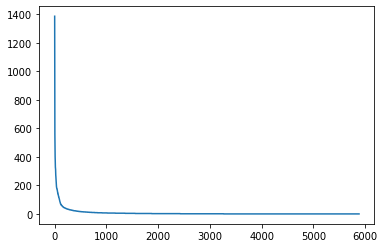

In [198]:
fig, ax = plt.subplots()
ax.plot(frequency['frequency'])
plt.show()

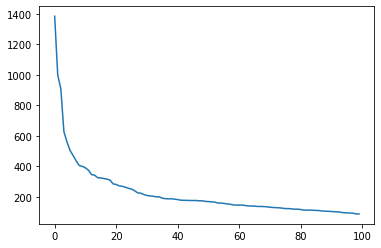

In [194]:
fig, ax = plt.subplots()
ax.plot(frequency['frequency'][0:100])
plt.show()

## Sentiment analisys

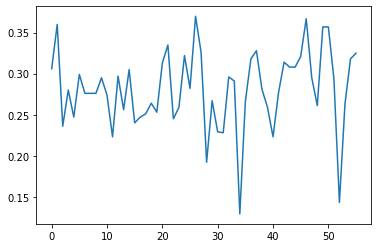

In [204]:
fig, ax = plt.subplots()
ax.plot('positive', data = grouped_results)
plt.show()

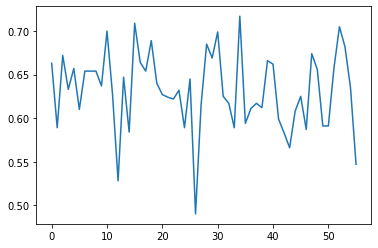

In [205]:
fig, ax = plt.subplots()
ax.plot('neutral', data = grouped_results)
plt.show()

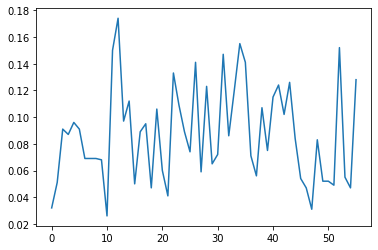

In [211]:
fig, ax = plt.subplots()
ax.plot('negative', data = grouped_results)
plt.show()

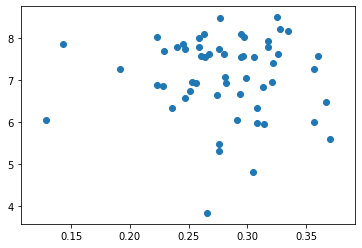

In [212]:
plt.scatter('positive', 'average', data = grouped_results)
plt.show()

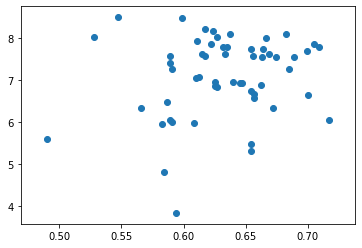

In [213]:
plt.scatter('neutral', 'average', data = grouped_results)
plt.show()

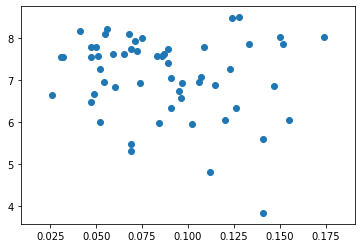

In [217]:
plt.scatter('negative', 'average', data = grouped_results)
plt.show()

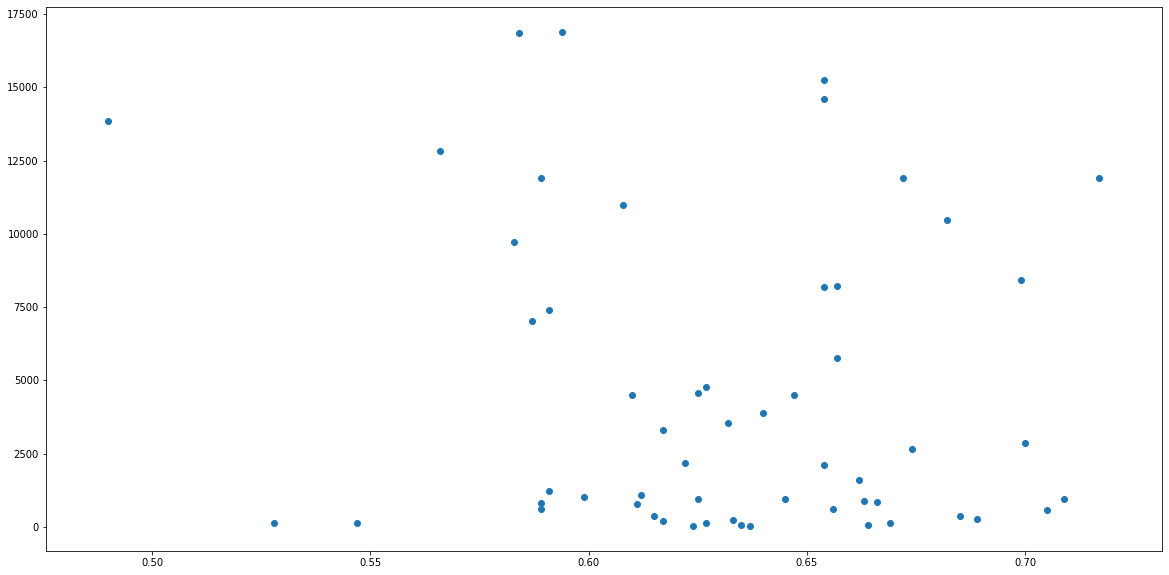

In [228]:
plt.figure(figsize=(20,10))
plt.scatter('neutral', 'Board Game Rank', data = grouped_results)

plt.show()